In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data preprocessing

In [109]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

## 1) Load data

In [110]:
csv_path ='/content/drive/MyDrive/Project/Project_Gotcha/ipynb/datasets/X_joint_nulldelall.csv'

In [111]:
DF = pd.read_csv(csv_path)

DF

,index,p_1,p_2
0,assault-falldown0,"380.343,134.948,358.107,162.386,355.5,163.694,...","495.219,138.845,517.383,163.653,514.745,162.35..."
1,assault-falldown0,"380.305,137.513,358.076,162.39,352.898,163.681...","487.311,137.525,509.543,162.376,505.647,162.32..."
2,assault-falldown0,"380.285,134.96,356.785,162.383,351.604,163.665...","484.767,136.251,506.958,162.33,505.55,162.328,..."
3,assault-falldown0,"380.254,134.954,354.209,162.368,350.323,163.62...","482.122,134.921,505.651,162.403,502.978,162.35..."
4,assault-falldown0,"376.403,138.798,351.592,162.372,350.262,163.64...","474.302,137.56,497.76,163.622,495.174,162.364,..."
...,...,...,...
139387,smoke-stand9,"522.551,144.064,536.966,181.901,517.351,180.63...","298.079,161.022,282.402,193.69,275.852,196.295..."
139388,smoke-stand9,"521.286,144.074,536.962,181.909,517.342,180.63...","298.08,161.009,281.104,193.665,274.604,196.283..."
139389,smoke-stand9,"522.551,144.066,536.961,181.906,517.345,180.63...","298.093,161.012,281.117,193.689,274.555,196.27..."
139390,smoke-stand9,"522.55,144.062,536.961,181.908,517.343,180.634...","298.119,161.01,281.093,193.652,273.267,195.009..."


## 2) Check Null Value

In [112]:
DF['p_1'].isnull().sum()

0

In [113]:
DF['p_2'].isnull().sum()

0

## 3) Make 'y'

In [161]:
def makeY(df, n_frame=32):
    df['index'] = [value.split('-')[0] for value in df['index'].values]
    y = df['index'].to_list()
    y = [y[i * n_frame:(i + 1) * n_frame] for i in range((len(y) + n_frame - 1) // n_frame )]
    y = [ys[0] for ys in y]

    encoder = LabelEncoder()    
    encoder.fit(y)
    classes = encoder.classes_
    y = encoder.transform(y)

    y = to_categorical(y)

    return y, classes

In [162]:
y, classes = makeY(DF)

In [163]:
y.shape

(4356, 3)

In [165]:
classes

array(['assault', 'normal', 'smoke'], dtype='<U7')

## 4) Make 'X'

In [117]:
def makeX(df, n_frame=32):
    df['people'] = df['p_1'] + ',' + df['p_2']
    xs = df['people'].to_list()

    data = []
    for rows in xs:
        elements = str(rows).split(',')
        for element in elements:
            data.append(float(element))

    x = np.array(data)
    x = x.reshape(-1, 32, 72)

    return x

In [118]:
X = makeX(DF)

In [119]:
X.shape

(4356, 32, 72)

## 5) Data Split

In [120]:
random_seed = 0
n_frame = 32

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=random_seed)

In [122]:
X_train.shape, y_train.shape

((3136, 32, 72), (3136, 3))

In [123]:
X_valid.shape, y_valid.shape

((784, 32, 72), (784, 3))

In [124]:
X_test.shape, y_test.shape

((436, 32, 72), (436, 3))

# 2. LSTM Modeling

In [125]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

import keras.backend as K

In [126]:
n_input = 72 # 두 사람의 동작(x,y) x 36
n_steps = 32 # per frames

n_hidden = 32
n_classes = len(y[0])

epochs = 100
batch_size = 128

## 1) Model define

In [127]:
K.clear_session()

model = Sequential()
model.add(Dense(n_hidden, activation='relu', input_shape=(n_steps, n_input)))
model.add(LSTM(n_hidden))
# model.add(LSTM(n_hidden))
model.add(Dense(n_classes, activation = 'softmax'))

In [128]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32, 32)            2336      
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 10,755
Trainable params: 10,755
Non-trainable params: 0
_________________________________________________________________


## 2) Model Compile

In [129]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## 3) Model Fit

In [130]:
%%time
hist = model.fit(X_train, y_train,
                 epochs = epochs,
                 batch_size = batch_size,
                 validation_data = (X_valid, y_valid))

Epoch 1/100
25/25 [==============================] - 2s 24ms/step - loss: 1.3584 - accuracy: 0.2981 - val_loss: 0.9294 - val_accuracy: 0.5893
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 0.8624 - accuracy: 0.5966 - val_loss: 0.6991 - val_accuracy: 0.6288
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 0.6627 - accuracy: 0.7383 - val_loss: 0.5661 - val_accuracy: 0.8827
Epoch 4/100
25/25 [==============================] - 0s 8ms/step - loss: 0.5349 - accuracy: 0.8859 - val_loss: 0.4769 - val_accuracy: 0.8801
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4640 - accuracy: 0.9243 - val_loss: 0.4073 - val_accuracy: 0.9043
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4742 - accuracy: 0.8851 - val_loss: 0.4279 - val_accuracy: 0.8852
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4144 - accuracy: 0.8930 - val_loss: 0.3361 - val_accuracy: 0.9426
Epoch 8/100


## 4) Visualization(Loss, Accuracy)

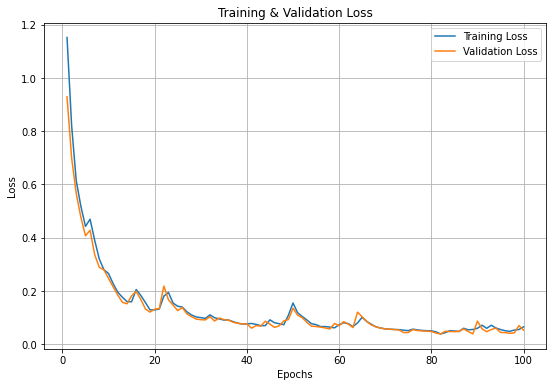

In [131]:
epochs = range(1, len(hist.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, hist.history['loss'])
plt.plot(epochs, hist.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

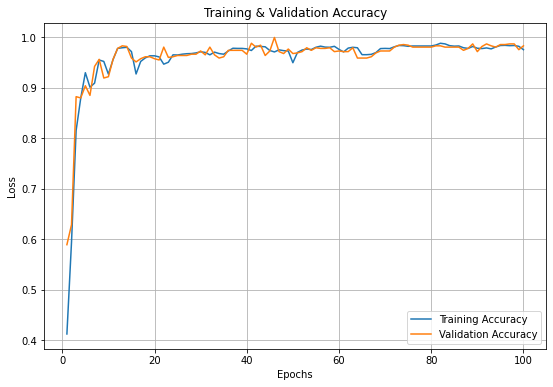

In [132]:
epochs = range(1, len(hist.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, hist.history['accuracy'])
plt.plot(epochs, hist.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

## 5) Model Evaluate 

In [133]:
loss, accuracy = model.evaluate(X_test, y_test,
                                batch_size = batch_size)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

4/4 [==============================] - 0s 4ms/step - loss: 0.0661 - accuracy: 0.9771
Loss = 0.06607
Accuracy = 0.97706


## 6) Model Save

In [143]:
abs_path = '/content/drive/MyDrive/Project/Project_Gotcha/models/'
model_name = 'lstm_our_data.h5'
final_path = abs_path + model_name

In [142]:
model.save(final_path)

# 3. Model Predict

## 1) Load Data

In [171]:
test_path = '/content/drive/MyDrive/Project/Project_Gotcha/ipynb/datasets/real_test.csv'

assault = pd.read_csv(test_path)
assault

,index,p_1,p_2
0,flip000000000008,"131.09,158.404,104.906,183.22,110.116,183.185,...","248.509,153.248,269.347,187.123,266.713,183.23..."
1,flip000000000009,"131.075,153.246,104.93,183.228,110.141,183.186...","251.095,154.528,270.695,187.155,266.793,183.27..."
2,flip000000000010,"131.052,153.234,107.52,183.257,115.369,183.25,...","252.397,155.805,271.984,187.136,266.782,183.28..."
3,flip000000000011,"137.531,153.186,110.139,183.29,120.575,184.531...","256.34,158.436,275.894,191.015,266.792,184.539..."
4,flip000000000012,"140.158,153.219,111.47,183.291,121.878,184.541...","260.209,159.702,277.204,191.078,268.082,185.83..."
5,flip000000000013,"141.517,153.2,114.042,184.541,125.776,185.819,...","265.428,159.734,279.828,192.304,271.97,185.861..."
6,flip000000000014,"150.535,153.197,120.573,185.866,128.411,189.74...","274.558,159.74,286.38,191.06,275.886,184.516,2..."
7,flip000000000015,"275.944,160.96,288.968,191.042,277.231,183.271...","151.901,154.499,124.515,187.143,129.663,191.02..."
8,flip000000000016,"278.479,159.724,292.869,189.744,279.816,183.26...","154.49,153.199,129.76,188.463,128.428,192.307,..."
9,flip000000000017,"285.043,159.676,298.049,189.758,287.599,184.51...","161.007,151.926,133.619,187.127,123.211,192.34..."


In [172]:
X_pre = makeX(assault)

X_pre.shape

(1, 32, 72)

## 2) Load Model

In [174]:
from keras.models import load_model

np.set_printoptions(precision=6, suppress=True) # np.array 표현 방식 변경 (지수 -> 실수)

In [175]:
loaded_model = load_model(final_path)

In [176]:
predict_dict = {}

predictions = loaded_model.predict(X_pre)

for idx, c in enumerate(classes):
    predict_dict[c] = predictions[0][idx]

print(predict_dict)

{'assault': 0.9962153, 'normal': 0.00023949315, 'smoke': 0.0035451262}


In [177]:
predict_class = np.argmax(predictions[0], axis=-1)

classes[predict_class]

'assault'